# ***Cardiovascular Differentiation via ECG and HRV - Analyzing Static v/s Dynamic Exercise Responses***

Biomedical Signal Processing (P-ITJEL-0024) - FINAL PROJECT



Authors: Mariela Talavera, Sneha Chaudhary and Daniel Mila




Accesing into Google drive files

In [ ]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing neurokit2 library

In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 12.4 MB/s eta 0:00:00


All importations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
from scipy.stats import shapiro, ttest_rel, wilcoxon


The dataset is organized hierarchically by Subject and Experimental Phase. For each subject, the recordings are segmented into five distinct conditions:

- Baseline
- Post-Isometric
- Recovery (Isometric)
- Post-Isotonic
- Recovery (Isotonic)

Within each phase directory, multiple file formats are generated (High Fidelity, Standard View, and Temporary Buffer). For this analysis, we will exclusively extract the High Fidelity files to ensure the highest signal quality.

Since the dataset contains recordings with varying sampling rates, specifically 1000 Hz for High Fidelity data versus 250 Hz for Standard View, we defined a helper function to automatically identify the file type. This step is crucial to ensure that the subsequent signal processing algorithms apply the correct frequency parameters to each recording.

In [ ]:
def detect_sampling_rate(filename):
    """
    Infers sampling rate from the filename.
    The files that are recorded on 1k are usually named like: ecg1k.dat, so we just have to look for that pattern on the naming
    """
    name_lower = filename.lower()
    if "1k" in name_lower or "1000" in name_lower:
        return 1000

    return 250

***PREPROCESSING***


We define now the preprocessing of the data.

For cleaning we'll use the function included on NEUROKIT2 python library. It applies a high-pass 0.5 Hz filter, so it removes baseline wander (the slow drifting of the signal caused by breathing or movement) without distorting the shape of the QRS complex too much. Also, it does not aggressively remove high frequencies (unlike a manual highcut=45 Hz). It preserves the sharp "spike" of the R-peak. Removing high frequencies (blurring the signal) can sometimes lower the R-peak amplitude, making detection harder if the signal is low voltage. But it hasn't been a hassle during the project performance so we didn't change it.

We will also use the ecg_peaks function for feature extraction (peaks), parameter useful for calculating the hrv.



In [ ]:
def preprocess_ecg(file_path):
    """
    Pipeline to preprocess ECG data and return r_peaks (array), quality, and sampling rate.
    """
    try:
        filename = os.path.basename(file_path)
        sampling_rate = detect_sampling_rate(filename)

        # loading data
        try:
            raw_data = np.loadtxt(file_path)
            if raw_data.ndim > 1: raw_data = raw_data[:, -1]
        except:
            with open(file_path, 'rb') as f:
                raw_data = np.frombuffer(f.read(), dtype=np.int16)

        if len(raw_data) == 0: return None, sampling_rate

        # -- cleaning (incluiding filtering) the data using the NEUROKIT2 library
        ecg_cleaned = nk.ecg_clean(raw_data, sampling_rate=sampling_rate, method="neurokit")
        ecg_normalized = nk.standardize(ecg_cleaned)

        # -- quality analysis
        quality_class = nk.ecg_quality(ecg_normalized, sampling_rate=sampling_rate, method="zhao2018")
        quality_map = {
            "Excellent": 1.0,
            "Barely acceptable": 0.5,
            "Unacceptable": 0.0
        }
        #get the numeric value (default to 0.0 if unknown)
        sqi = quality_map.get(quality_class, 0.0)

        # -- peak detection
        _, info = nk.ecg_peaks(ecg_normalized, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        # -- sort peaks
        r_peaks = np.sort(r_peaks.astype(int))

        return r_peaks, sqi, sampling_rate

    except Exception as e:
        print(f"   [ERROR] in {os.path.basename(file_path)}: {e}")
        return None, 0.0,  250


***PROCESSING***

Due to the limited duration of our recordings (<30 seconds), performing a reliable Frequency Domain analysis (specifically identifying Low Frequency or LF bands) is not feasible. The LF band operates within the 0.04 Hz−0.15 Hz interval. A frequency of 0.04 Hz requires a period of 25 seconds (T=1/f) to complete a single full cycle. Consequently, a <30-second recording captures approximately one cycle, which is insufficient for a statistically valid spectral analysis.

Proposed Solution: Time-Domain Analysis (RMSSD) To address this limitation, we will utilize RMSSD (Root Mean Square of Successive Differences). This metric quantifies abrupt changes in heart rate beat-to-beat and is strongly correlated with High-Frequency (HF) spectral power. It serves as a reliable marker for parasympathetic (vagal) tone without requiring long recording durations.


Interpretation of RMSSD:

- High RMSSD: Indicates Parasympathetic dominance. This suggests the subject has recovered or is in a rested state.

- Low RMSSD: Indicates Parasympathetic withdrawal. This implies the subject is currently under stress or sympathetic dominance.

In [ ]:
def calculate_rmssd_strict(r_peaks, fs=250):
    """

   Calculation of RMSSD but preventing from impossible intervals.
    """

    if len(r_peaks) < 2:
        return None

    # we get the intervals on [ms]
    rr_intervals = np.diff(r_peaks) / fs * 1000

    # first filter -- strict
    # less than 300ms (uneal tachycardia or noise)
    # more than 1300ms (lost beat or extreme tachycardia)
    # NOTE: 1300ms = 46 bpm. If they are athletes sleeping it could be low, but it was not the case of analysis.
    valid_rr = rr_intervals[(rr_intervals > 300) & (rr_intervals < 1300)]

    if len(valid_rr) < 2:
        return None

    # second filter - stadistical filter (OUTLIER REMOVAL)
    # we remove any beat which its value is 30 far from the local average.
    mean_rr = np.mean(valid_rr)
    upper_limit = mean_rr * 1.30
    lower_limit = mean_rr * 0.70

    clean_rr = valid_rr[(valid_rr > lower_limit) & (valid_rr < upper_limit)]

    if len(clean_rr) < 2:
        return None

    # rmssd calculation
    diff_rr = np.diff(clean_rr)
    rmssd = np.sqrt(np.mean(diff_rr**2))

    return rmssd


PREPROCESSING AND PROCESSING EXECUTION

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/bsp final project/ECG measures data"

STAGES_MAP = {
    '1_Baseline': 'Baseline',
    '2_Post_Isometric': 'Post_Iso',
    '3_Recovery_Isometric': 'Rec_Iso',
    '4_Post_Isotonic': 'Post_Ton',
    '5_Recovery_Isotonic': 'Rec_Ton'
}

results = []

if os.path.exists(DATASET_PATH):
    subjects = sorted([d for d in os.listdir(DATASET_PATH) if d.startswith('Subject')])

    for subject in subjects:
        row = {'Subject': subject}
        for folder_name, logic_name in STAGES_MAP.items():

            # search file
            path_base = os.path.join(DATASET_PATH, subject, folder_name)
            path_1k = os.path.join(path_base, 'ecg1k.dat')
            path_std = os.path.join(path_base, 'ecg.dat')

            final_path = path_1k if os.path.exists(path_1k) else path_std

            rmssd_val = None

            if os.path.exists(final_path):
                # 1. preprocess (for finding peaks)
                r_peaks, sqi, fs = preprocess_ecg(final_path)

                # 2. rmssd calculation
                if r_peaks is not None:
                    rmssd_val = calculate_rmssd_strict(r_peaks, fs)

            row[f"{logic_name}_RMSSD"] = rmssd_val

        # delts calculation
        if row.get('Rec_Iso_RMSSD') and row.get('Post_Iso_RMSSD'):
            row['Delta_Isometric'] = row['Rec_Iso_RMSSD'] - row['Post_Iso_RMSSD']
        else:
            row['Delta_Isometric'] = None

        if row.get('Rec_Ton_RMSSD') and row.get('Post_Ton_RMSSD'):
            row['Delta_Isotonic'] = row['Rec_Ton_RMSSD'] - row['Post_Ton_RMSSD']
        else:
            row['Delta_Isotonic'] = None

        results.append(row)

    # results: ==========================================
    df = pd.DataFrame(results)

    desired_cols = ['Subject', 'Baseline_RMSSD',
                    'Post_Iso_RMSSD', 'Rec_Iso_RMSSD', 'Delta_Isometric',
                    'Post_Ton_RMSSD', 'Rec_Ton_RMSSD', 'Delta_Isotonic']

    final_cols = [c for c in desired_cols if c in df.columns]
    print(df[final_cols].round(2).to_markdown(index=False))

else:
    print(f"path not found: {DATASET_PATH}")


| Subject    |   Baseline_RMSSD |   Post_Iso_RMSSD |   Rec_Iso_RMSSD |   Delta_Isometric |   Post_Ton_RMSSD |   Rec_Ton_RMSSD |   Delta_Isotonic |
|:-----------|-----------------:|-----------------:|----------------:|------------------:|-----------------:|----------------:|-----------------:|
| Subject_01 |           105.51 |            60.35 |           47.26 |            -13.08 |           102.65 |           99.39 |            -3.26 |
| Subject_02 |            39.69 |            13.01 |           37.23 |             24.22 |            40.08 |           14.09 |           -25.99 |
| Subject_03 |            65.36 |            33.1  |           32.48 |             -0.62 |            11.94 |           33.07 |            21.13 |
| Subject_04 |            16.35 |             9.2  |           19.21 |             10.01 |             6.63 |            8.53 |             1.9  |
| Subject_05 |            74.38 |            56.11 |           74.23 |             18.12 |            68.47 |         

The data highlights distinct individual recovery profiles. While some subjects (like Subject 05 in Isometric) show a clear "rebound" in vagal tone immediately after exercise, others (like Subject 01) show a paradoxical drop in RMSSD during the recovery window. We will analyze these results statistically so we can extract relevant conclusions.

***Statistical Validation***

Before drawing conclusions, we must validate the significance of our results. We are comparing the 'Iso' and 'Ton' phases for both RMSSD and MAP.
We will add a new dataset into the analysis: the blood pressure recordings. Those are stored on a csv file. The function for that is defined in the beginning.

Process:

- Check Normality: Use shapiro() to confirm if data follows a normal curve.

- Compare Means: Use ttest_rel() (Paired T-Test) to see if the difference between the two phases is significant (p<0.05).

This ensures that any differences we see in the tables above are mathematically valid and not just random noise.

In [ ]:
def parse_bp_cell(cell_value):
    try:
        if pd.isna(cell_value) or str(cell_value).strip() == "": return np.nan

        clean_str = str(cell_value).replace('/', ' ').replace(';', ' ')
        parts = clean_str.split()
        if len(parts) < 2: return np.nan
        sbp = float(parts[0])
        dbp = float(parts[1])
        return dbp + (1/3) * (sbp - dbp) # MAP
    except:
        return np.nan

def process_bp_csv(csv_path):
    if not os.path.exists(csv_path):
        print(f"Error: No existe {csv_path}")
        return pd.DataFrame()

    try:

        df = pd.read_csv(csv_path, sep=';', encoding='utf-8')

        if 'Unnamed' in str(df.columns[0]) or df.columns[0].strip() == '':
            df.rename(columns={df.columns[0]: 'Subject'}, inplace=True)

        df.columns = [c.strip() for c in df.columns]


        col_iso = next((c for c in df.columns if '2' in c and 'Isometric' in c), None)
        col_ton = next((c for c in df.columns if '4' in c and 'Isotonic' in c), None)

        if not col_iso or not col_ton:
            print("Error: 2_Post_Iso / 4_Post_Iso not found")
            return pd.DataFrame()

        results = []
        for _, row in df.iterrows():
            subj = row['Subject']
            if pd.notna(subj) and str(subj).strip() != "":
                results.append({
                    'Subject': str(subj).strip(),
                    'MAP_Iso': parse_bp_cell(row[col_iso]),
                    'MAP_Ton': parse_bp_cell(row[col_ton])
                })
        return pd.DataFrame(results)
    except Exception as e:
        print(f"csv error while processing: {e}")
        return pd.DataFrame()

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/bsp final project/ECG measures data"
BP_CSV_PATH = "/content/drive/MyDrive/bsp final project/blood_pressure.csv"

#ecg

rmssd_data = []
if os.path.exists(DATASET_PATH):
    subjects = sorted([d for d in os.listdir(DATASET_PATH) if d.startswith('Subject')])
    for subj in subjects:

        path_iso = os.path.join(DATASET_PATH, subj, '3_Recovery_Isometric')
        path_ton = os.path.join(DATASET_PATH, subj, '5_Recovery_Isotonic')

        # auxiliary function for search
        def get_rmssd(folder):
            f_path = os.path.join(folder, 'ecg1k.dat') if os.path.exists(os.path.join(folder, 'ecg1k.dat')) else os.path.join(folder, 'ecg.dat')
            if os.path.exists(f_path):
                p, sqi, fs = preprocess_ecg(f_path)
                if p is not None: return calculate_rmssd_strict(p, fs)
            return np.nan

        rmssd_data.append({
            'Subject': subj,
            'RMSSD_Iso': get_rmssd(path_iso),
            'RMSSD_Ton': get_rmssd(path_ton)
        })
    df_rmssd = pd.DataFrame(rmssd_data)
else:
    print("ECG path not found")
    df_rmssd = pd.DataFrame()

# blood pressure

df_bp = process_bp_csv(BP_CSV_PATH)


# stadistics

if not df_rmssd.empty and not df_bp.empty:

    df_final = pd.merge(df_rmssd, df_bp, on='Subject', how='inner')

    print("\n=== table of contents ===")
    print(df_final.round(2).to_markdown(index=False))

    def run_stats(iso, ton, name):
        clean = pd.DataFrame({'Iso': iso, 'Ton': ton}).dropna()
        if len(clean) < 3: return
        diff = clean['Iso'] - clean['Ton']
        _, p_shapiro = shapiro(diff)
        normality = "Normal" if p_shapiro > 0.05 else "Non-Normal"

        if normality == "Normal":
            test_name, p_val = "T-Test pared", ttest_rel(clean['Iso'], clean['Ton'])[1]
        else:
            test_name, p_val = "Wilcoxon", wilcoxon(clean['Iso'], clean['Ton'])[1]

        signif = "**relevant**" if p_val < 0.05 else "non relevant"
        print(f"\n--- analysis of {name} ---")
        print(f"Normality (Shapiro): p={p_shapiro:.4f} ({normality})")
        print(f"Test: {test_name} | p-value: {p_val:.4f} -> {signif}")

    # Ejecutar tests
    run_stats(df_final['RMSSD_Iso'], df_final['RMSSD_Ton'], "RMSSD (Vagal tone)")
    run_stats(df_final['MAP_Iso'], df_final['MAP_Ton'], "MAP (average blood pressure)")

else:
    print("\nError: data could not be joined")


=== table of contents ===
| Subject    |   RMSSD_Iso |   RMSSD_Ton |   MAP_Iso |   MAP_Ton |
|:-----------|------------:|------------:|----------:|----------:|
| Subject_01 |       47.26 |       99.39 |    101.67 |    110    |
| Subject_02 |       37.23 |       14.09 |    110.33 |    125    |
| Subject_03 |       32.48 |       33.07 |     97.33 |    104    |
| Subject_04 |       19.21 |        8.53 |    132    |    110.67 |
| Subject_05 |       74.23 |       46.26 |     97.33 |    123    |
| Subject_06 |       32.49 |       30.6  |    101    |    127.67 |

--- analysis of RMSSD (Vagal tone) ---
Normality (Shapiro): p=0.1317 (Normal)
Test: T-Test pared | p-value: 0.8823 -> non relevant

--- analysis of MAP (average blood pressure) ---
Normality (Shapiro): p=0.2551 (Normal)
Test: T-Test pared | p-value: 0.2173 -> non relevant


/tmp/ipython-input-121017718.py:32: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='Condition', y='Value', data=df_long,
/tmp/ipython-input-121017718.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Value', data=df_long, ax=axes[1], width=0.4, palette="pastel")


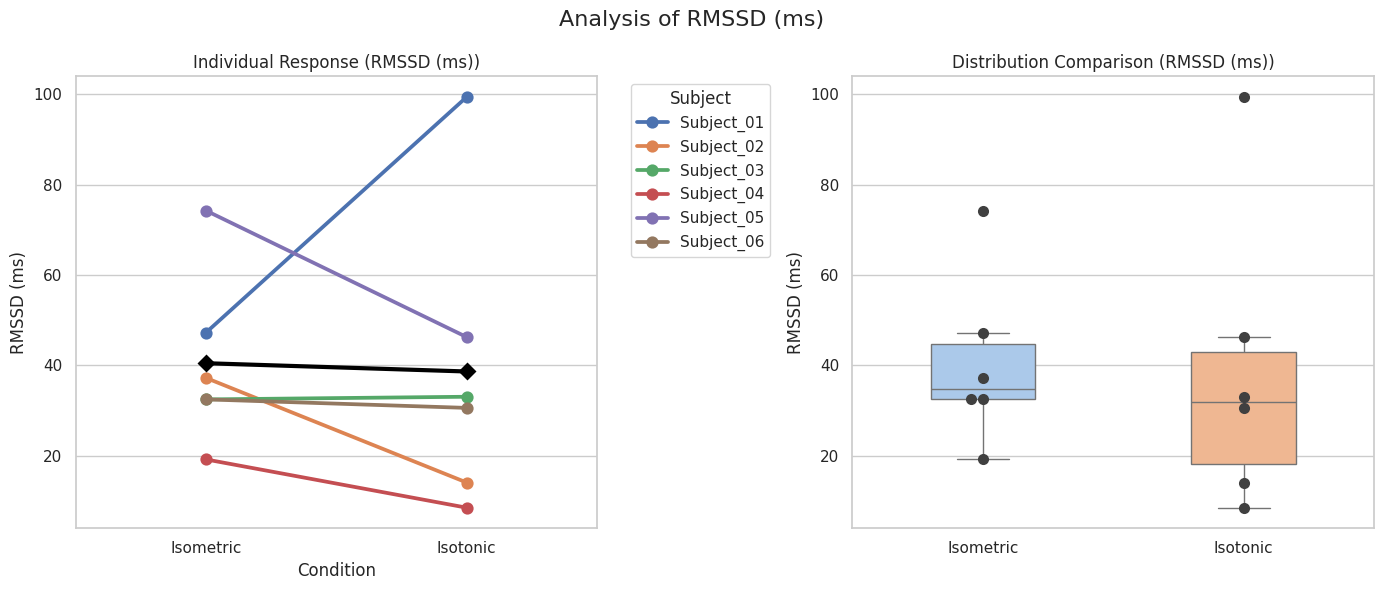

/tmp/ipython-input-121017718.py:32: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='Condition', y='Value', data=df_long,
/tmp/ipython-input-121017718.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Value', data=df_long, ax=axes[1], width=0.4, palette="pastel")


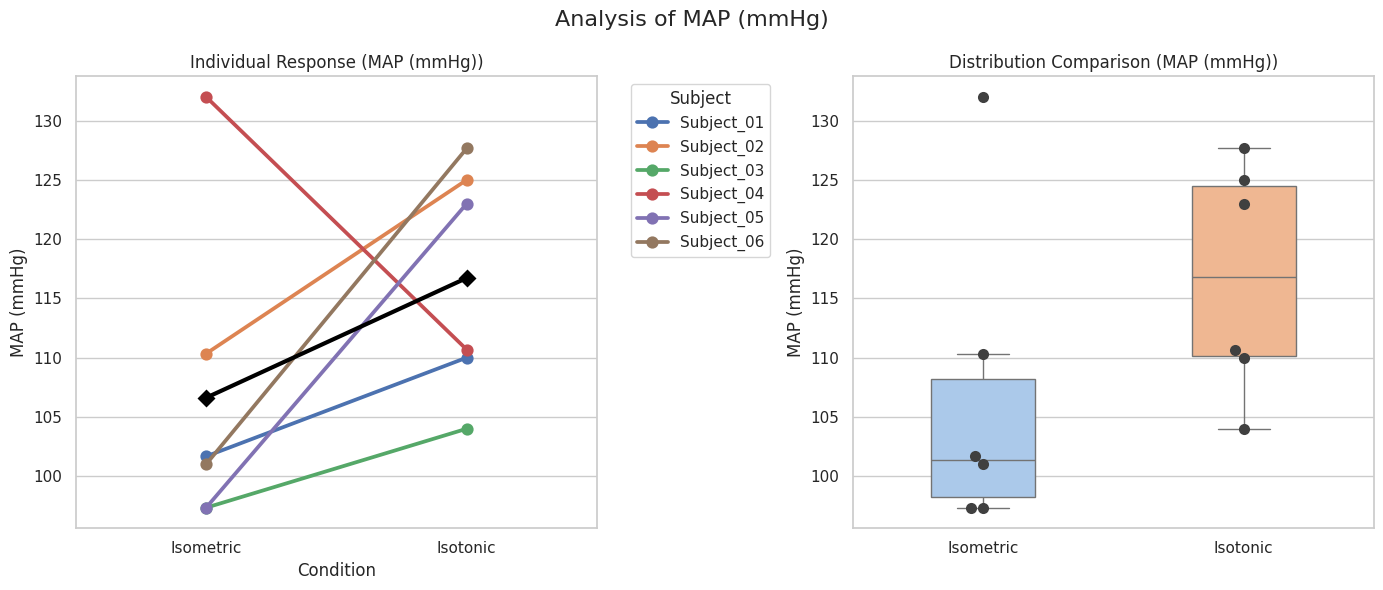

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar estilo visual
sns.set(style="whitegrid")

def plot_results(df, measure_name, col_iso, col_ton):
    """
    Generates a figure with two subplots:
    1. Paired Slopegraph (Spaghetti plot)
    2. Boxplot with individual points
    """
    # Preparar datos en formato 'long' para Seaborn
    df_long = pd.melt(df, id_vars=['Subject'], value_vars=[col_iso, col_ton],
                      var_name='Condition', value_name='Value')

    # Renombrar condiciones para que quede bonito en el gráfico
    df_long['Condition'] = df_long['Condition'].replace({col_iso: 'Isometric', col_ton: 'Isotonic'})

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Analysis of {measure_name}', fontsize=16)

    # --- GRAPH 1: Spaghetti Plot (Paired Individual Changes) ---
    # Dibujamos una línea por cada sujeto
    # Note: 'errorbar=None' removes the error bars.
    sns.pointplot(x='Condition', y='Value', hue='Subject', data=df_long,
                  ax=axes[0], dodge=False, markers='o', errorbar=None)

    # Línea de tendencia media (opcional, en negro grueso)
    # We use typical matplotlib kwargs like 'linewidth' if needed, but defaults are usually fine.
    sns.pointplot(x='Condition', y='Value', data=df_long,
                  ax=axes[0], color='black', markers='D', join=True, errorbar=None)

    # Customizing the black mean line appearance manually (optional polish)
    plt.setp(axes[0].lines[-1], linewidth=3) # Make the last line (the mean) thicker

    axes[0].set_title(f'Individual Response ({measure_name})')
    axes[0].set_ylabel(measure_name)
    axes[0].legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')

    # --- GRAPH 2: Boxplot + Swarmplot (Distribution) ---
    sns.boxplot(x='Condition', y='Value', data=df_long, ax=axes[1], width=0.4, palette="pastel")
    # Añadimos los puntos individuales encima
    sns.swarmplot(x='Condition', y='Value', data=df_long, ax=axes[1], color='0.25', size=8)

    axes[1].set_title(f'Distribution Comparison ({measure_name})')
    axes[1].set_ylabel(measure_name)
    axes[1].set_xlabel('')

    plt.tight_layout()
    plt.show()

# --- EXECUTE THE GRAPHS ---
# Asegúrate de tener df_final creado previamente
if 'df_final' in locals() and not df_final.empty:
    plot_results(df_final, "RMSSD (ms)", "RMSSD_Iso", "RMSSD_Ton")
    plot_results(df_final, "MAP (mmHg)", "MAP_Iso", "MAP_Ton")
else:
    print("DataFrame 'df_final' not found. Run the statistics block first.")

**DISCUSSION**

The aim of this study is analyzing the hemodynamic (MAP) and autonomic (RMSSD) responses to Isometric versus Isotonic exercise protocols. Based on the statistical validation and visual inspection of the data, we draw the following conclusions:

1. Hemodynamic Response (MAP) As illustrated in the MAP slopegraph, there is a prevalent physiological trend: 83% of subjects (5 out of 6) exhibited an increase in Mean Arterial Pressure during the Isotonic phase compared to the Isometric phase. However, the statistical significance of this trend (p>0.05) was compromised by Subject 04, who acted as a substantial outlier by demonstrating a sharp decrease in pressure. This suggests that while Isotonic exercise generally places a higher hemodynamic demand on this cohort, individual regulation can vary significantly.

2. Autonomic Response (RMSSD & Recovery Deltas) The analysis of Heart Rate Variability reveals that the vagal response to these exercises is highly idiosyncratic (individual-specific), with no uniform group adaptation.

Visual Variability: The RMSSD plots show bidirectional responses. While Subject 01 experienced a massive increase in vagal tone (indicating strong recovery), Subjects 02 and 05 showed a marked withdrawal.

Recovery Efficiency (The Deltas): The data table highlights critical differences in recovery capacity. Positive Deltas (e.g., Subject 02 in Isometric, Δ+24.22) indicate successful parasympathetic reactivation. Conversely, Negative Deltas (e.g., Subject 06 in Isometric, Δ−32.97) suggest a delayed recovery or sustained sympathetic stress.

We conclude that while Isotonic exercise tends to elicit a higher pressure response, the autonomic recovery (RMSSD) is not determined by the exercise type but rather by the individual's baseline physiological status. Future studies should increase the sample size (N>20) to mitigate the impact of outliers like Subject 04.